# 나의 첫번째 캐글 경진대회

## 1. 사전작업

#### 필요한 라이브러리 import 하기

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

#### 시각화 위한 작업

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### 데이터 경로 지정하기

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


---

## 2. 데이터 살펴보기

#### 데이터 불러오기

In [4]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

# 학습데이터 : 15035개, 테스트데이터 : 6468개
# 테스트데이터는 price가 없으므로 컬럼이 하나 적음

train data dim : (15035, 21)
sub data dim : (6468, 20)


#### 학습데이터에서 라벨 제거하기

In [5]:
y = data['price']        # price 컬럼은 따로 y라는 변수에 저장 후 컬럼 지워줌
del data['price']        # pandas.DataFrame.drop도 사용가능

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### 학습데이터와 테스트데이터 합치기

In [6]:
# 모델을 학습시키기 전에, 전체 데이터에 대해 탐색해보기 위해 두 데이터를 pd.concat으로 합쳐봄

train_len = len(data) # train_len에 training data의 개수를 저장해서 추후에 학습데이터만 불러올 수 있는 인덱스로 사용
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


#### 데이터 확인해보기

In [7]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


각 변수들이 나타내는 의미

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트 (캐글 측의 변수 설명 오류로 수정)
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트 (캐글 측의 변수 설명 오류로 수정)

---

## 3. 간단한 전처리

각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리함

#### 1) 결측치 확인

먼저 데이터에 결측치가 있는지 확인한다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있다.

<AxesSubplot:>

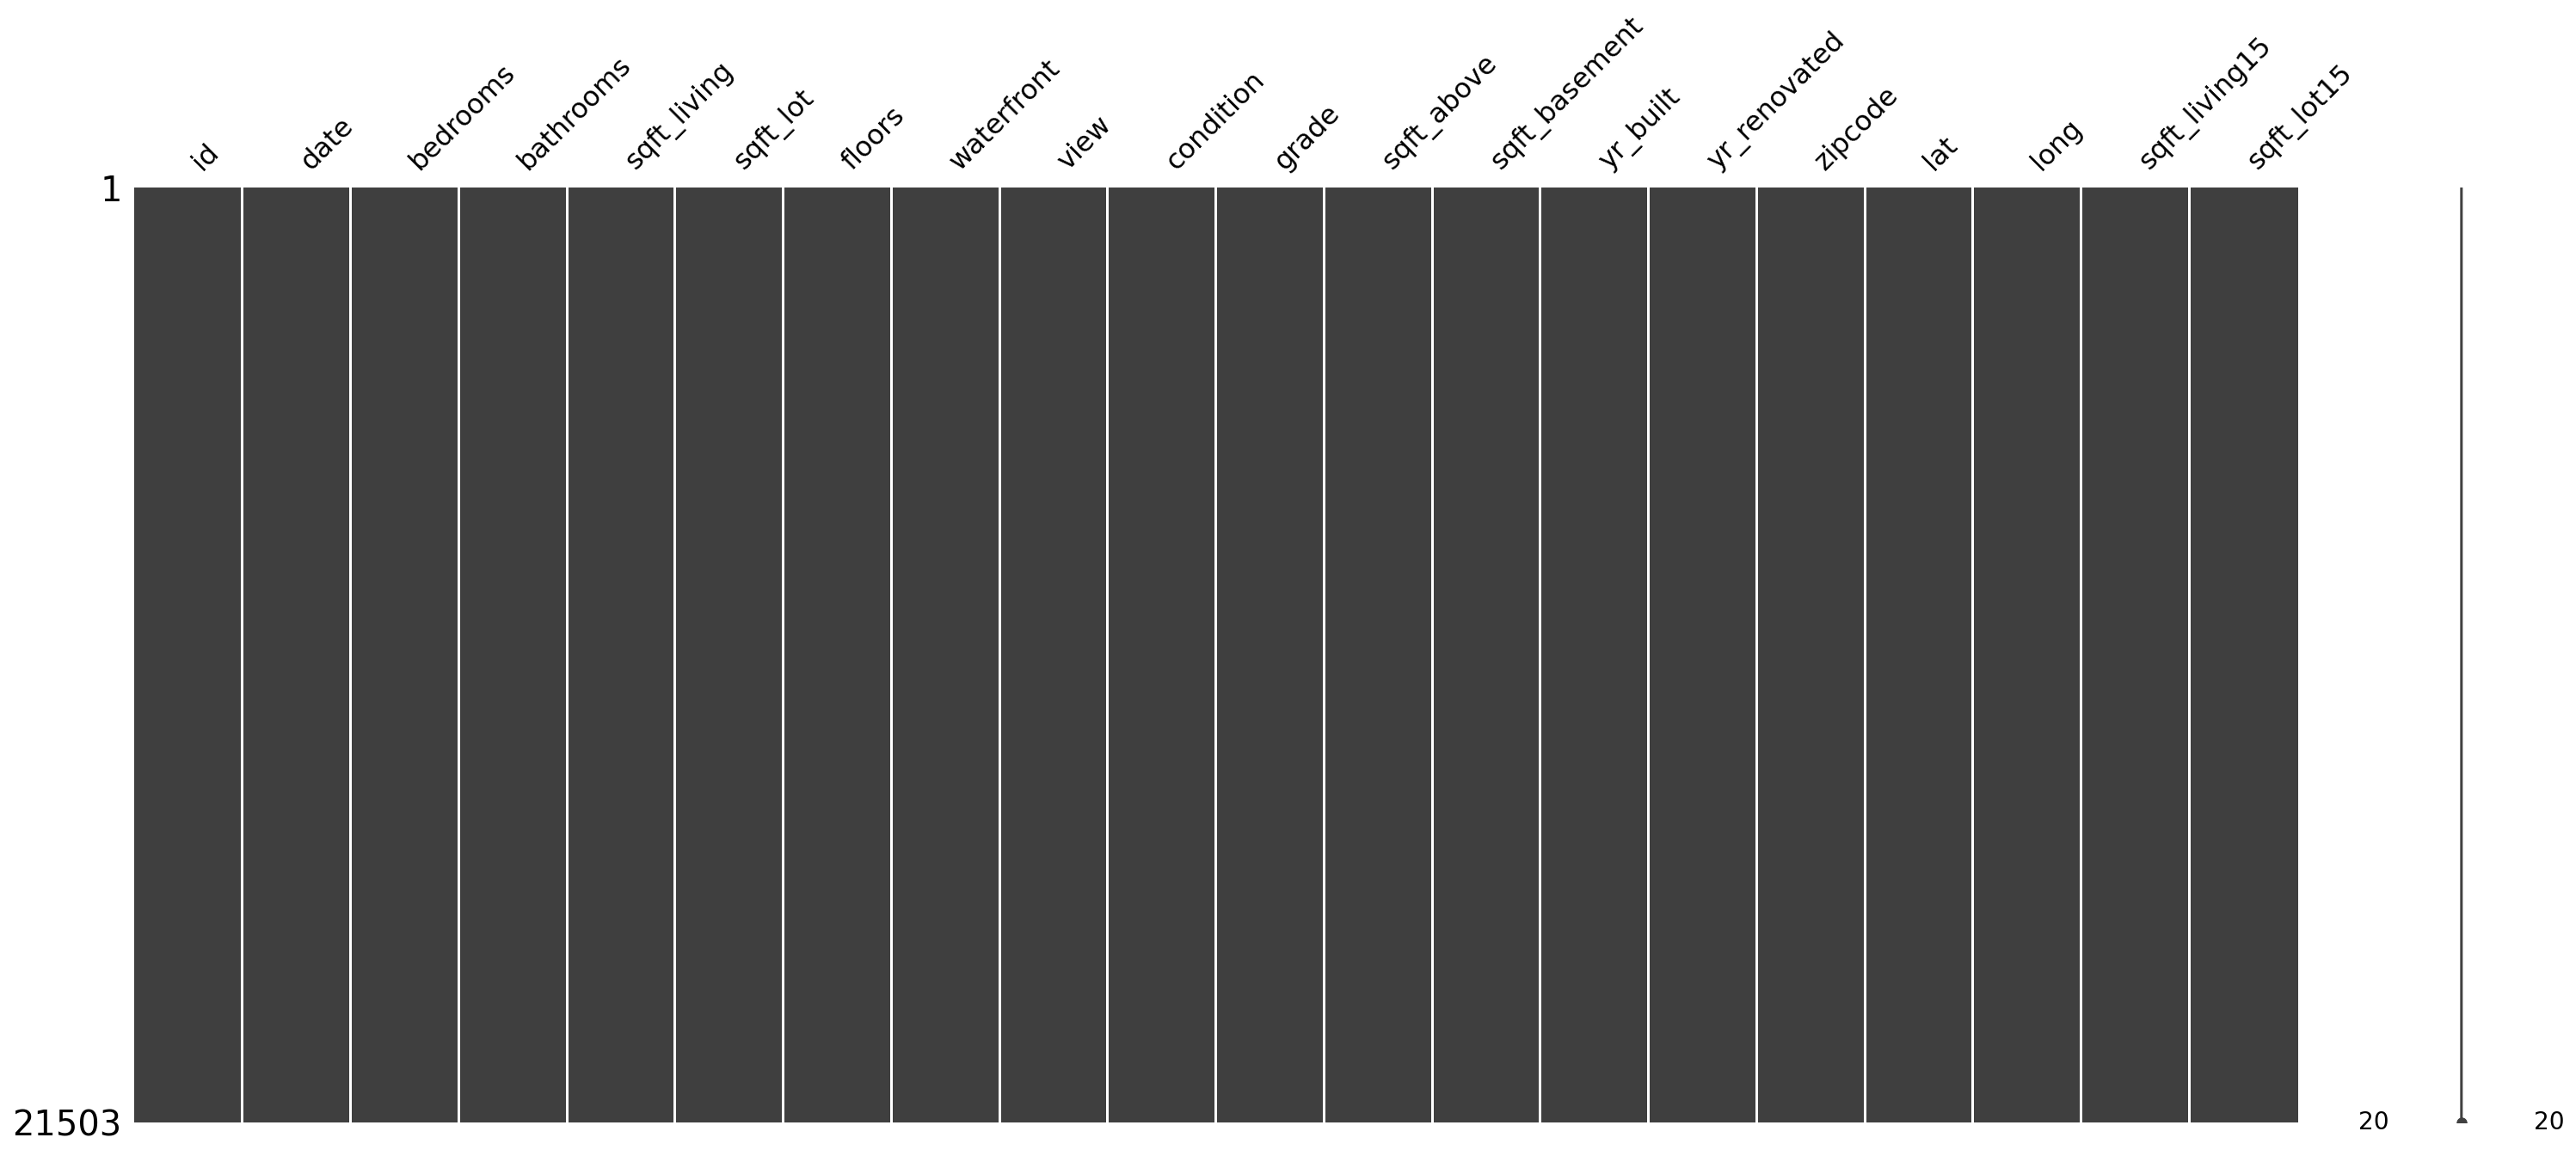

In [8]:
# 빈 데이터와 전체 데이터의 분포를 확인하는 전처리 작업

msno.matrix(data)

# data라는 DataFrame을 매트릭스 모양 그대로 시각화
# 만약 특정 row, col에 NaN이라는 결측치가 있었다면 해당 부분이 하얗게 나옴

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴봐야한다.

In [9]:
# 직접 결측치의 개수를 출력해서 확인하는 방법
for c in data.columns:
    null_check = pd.isnull(data[c])
    null_data = data.loc[null_check, c]
    print('{}: {}'.format(c, len(null_data.values)))
    
# 한번에 작성하면 이렇게 됨
# for c in data.columns:
    # print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id: 0
date: 0
bedrooms: 0
bathrooms: 0
sqft_living: 0
sqft_lot: 0
floors: 0
waterfront: 0
view: 0
condition: 0
grade: 0
sqft_above: 0
sqft_basement: 0
yr_built: 0
yr_renovated: 0
zipcode: 0
lat: 0
long: 0
sqft_living15: 0
sqft_lot15: 0


#### 2) id, date 변수 정리

id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거한다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만든다.

In [10]:
# 나중에 예측결과 제출할 때를 대비하여 sub_id 변수에 따로 저장

sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [11]:
# date 컬럼은 apply 함수로 필요한 부분만 잘라줌

data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)
# 20141013T000000 형식의 데이터를 연/월 데이터만 사용하기 위해 201410까지 자르기 위한 것
# date를 정수형으로 처리함으로써 나중에 예측 위한 특성으로 활용할 수 있게 함

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### 3) 각 변수들의 분포 확인

한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있다.

시각화 코드를 통해 date 제외한 18개 컬럼에 대해 (9행 2열에) 한번에 모든 그래프를 그려준다.<br>
kdeplot은 이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인할 수 있도록 해주는 함수이다.

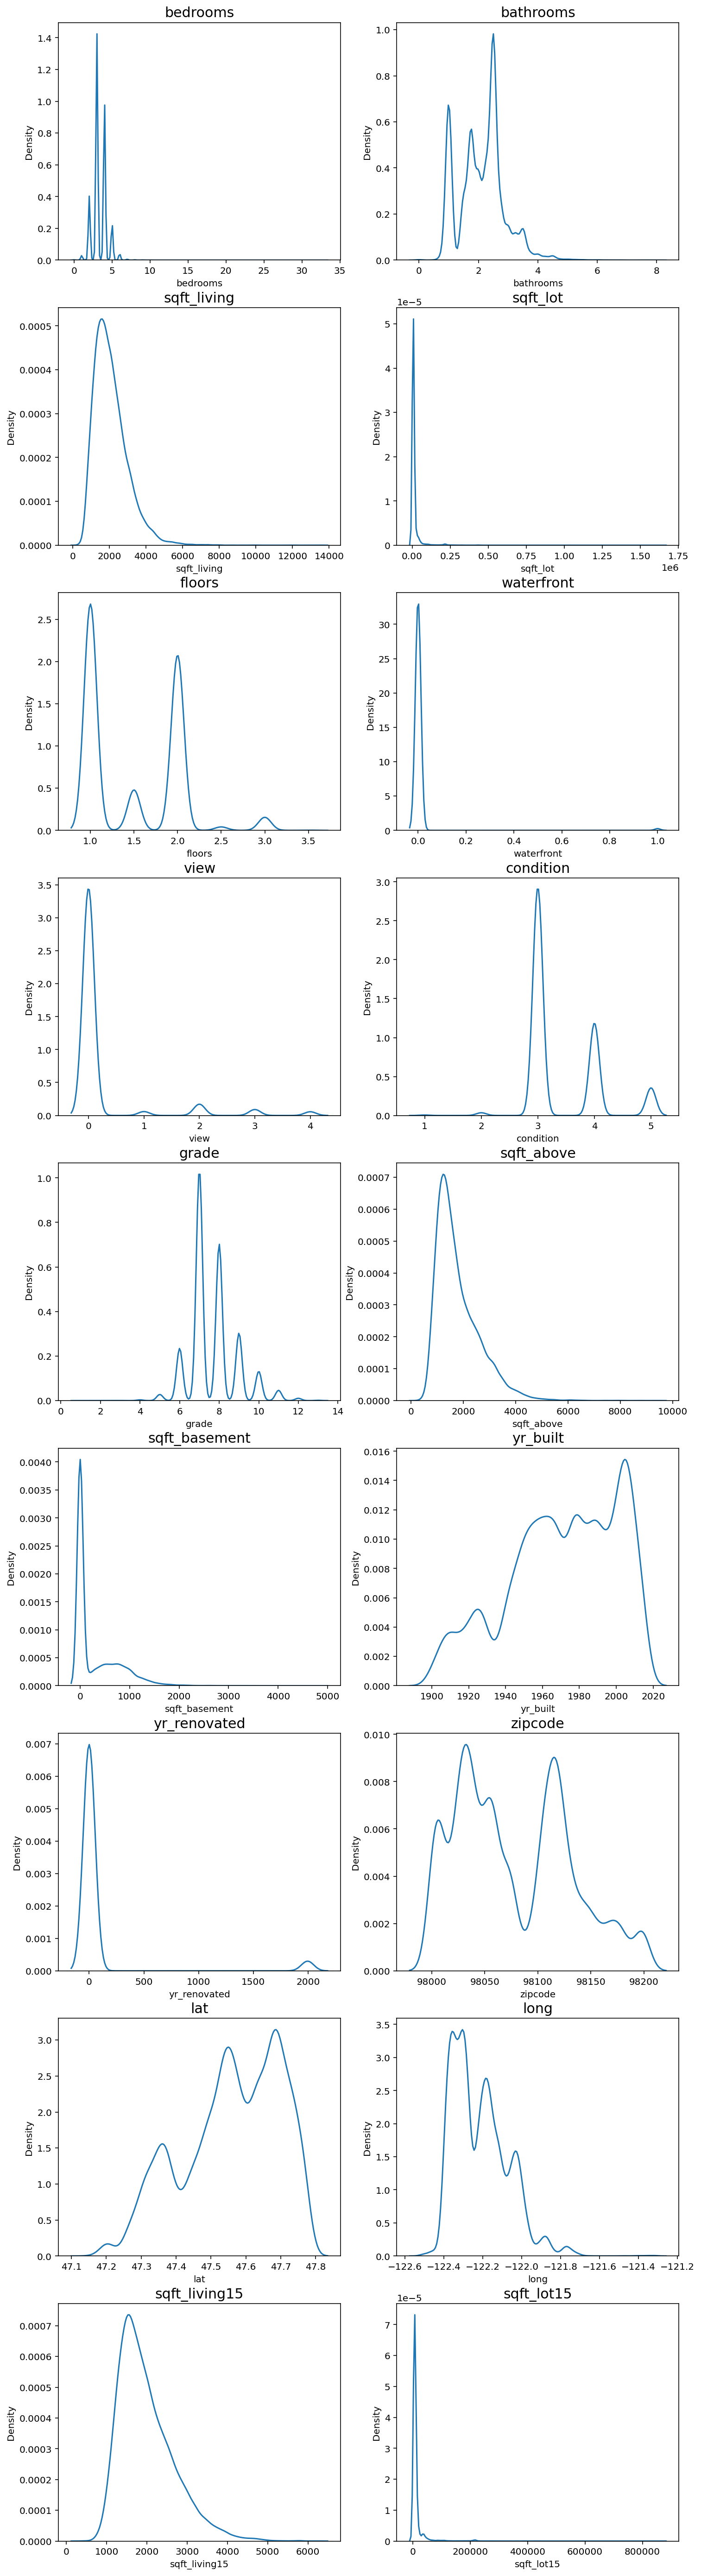

In [12]:
# 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절하면 됨
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

# date 변수(count==0인 경우)는 제외하고 분포를 확인
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

위 그래프 중에서 bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 한쪽으로 치우친 경향을 보인다.

#### 4) 치우친 분포들 조정

이렇게 한 쪽으로 치우친 분포의 경우에는 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포에 가깝게 만들 수 있다.

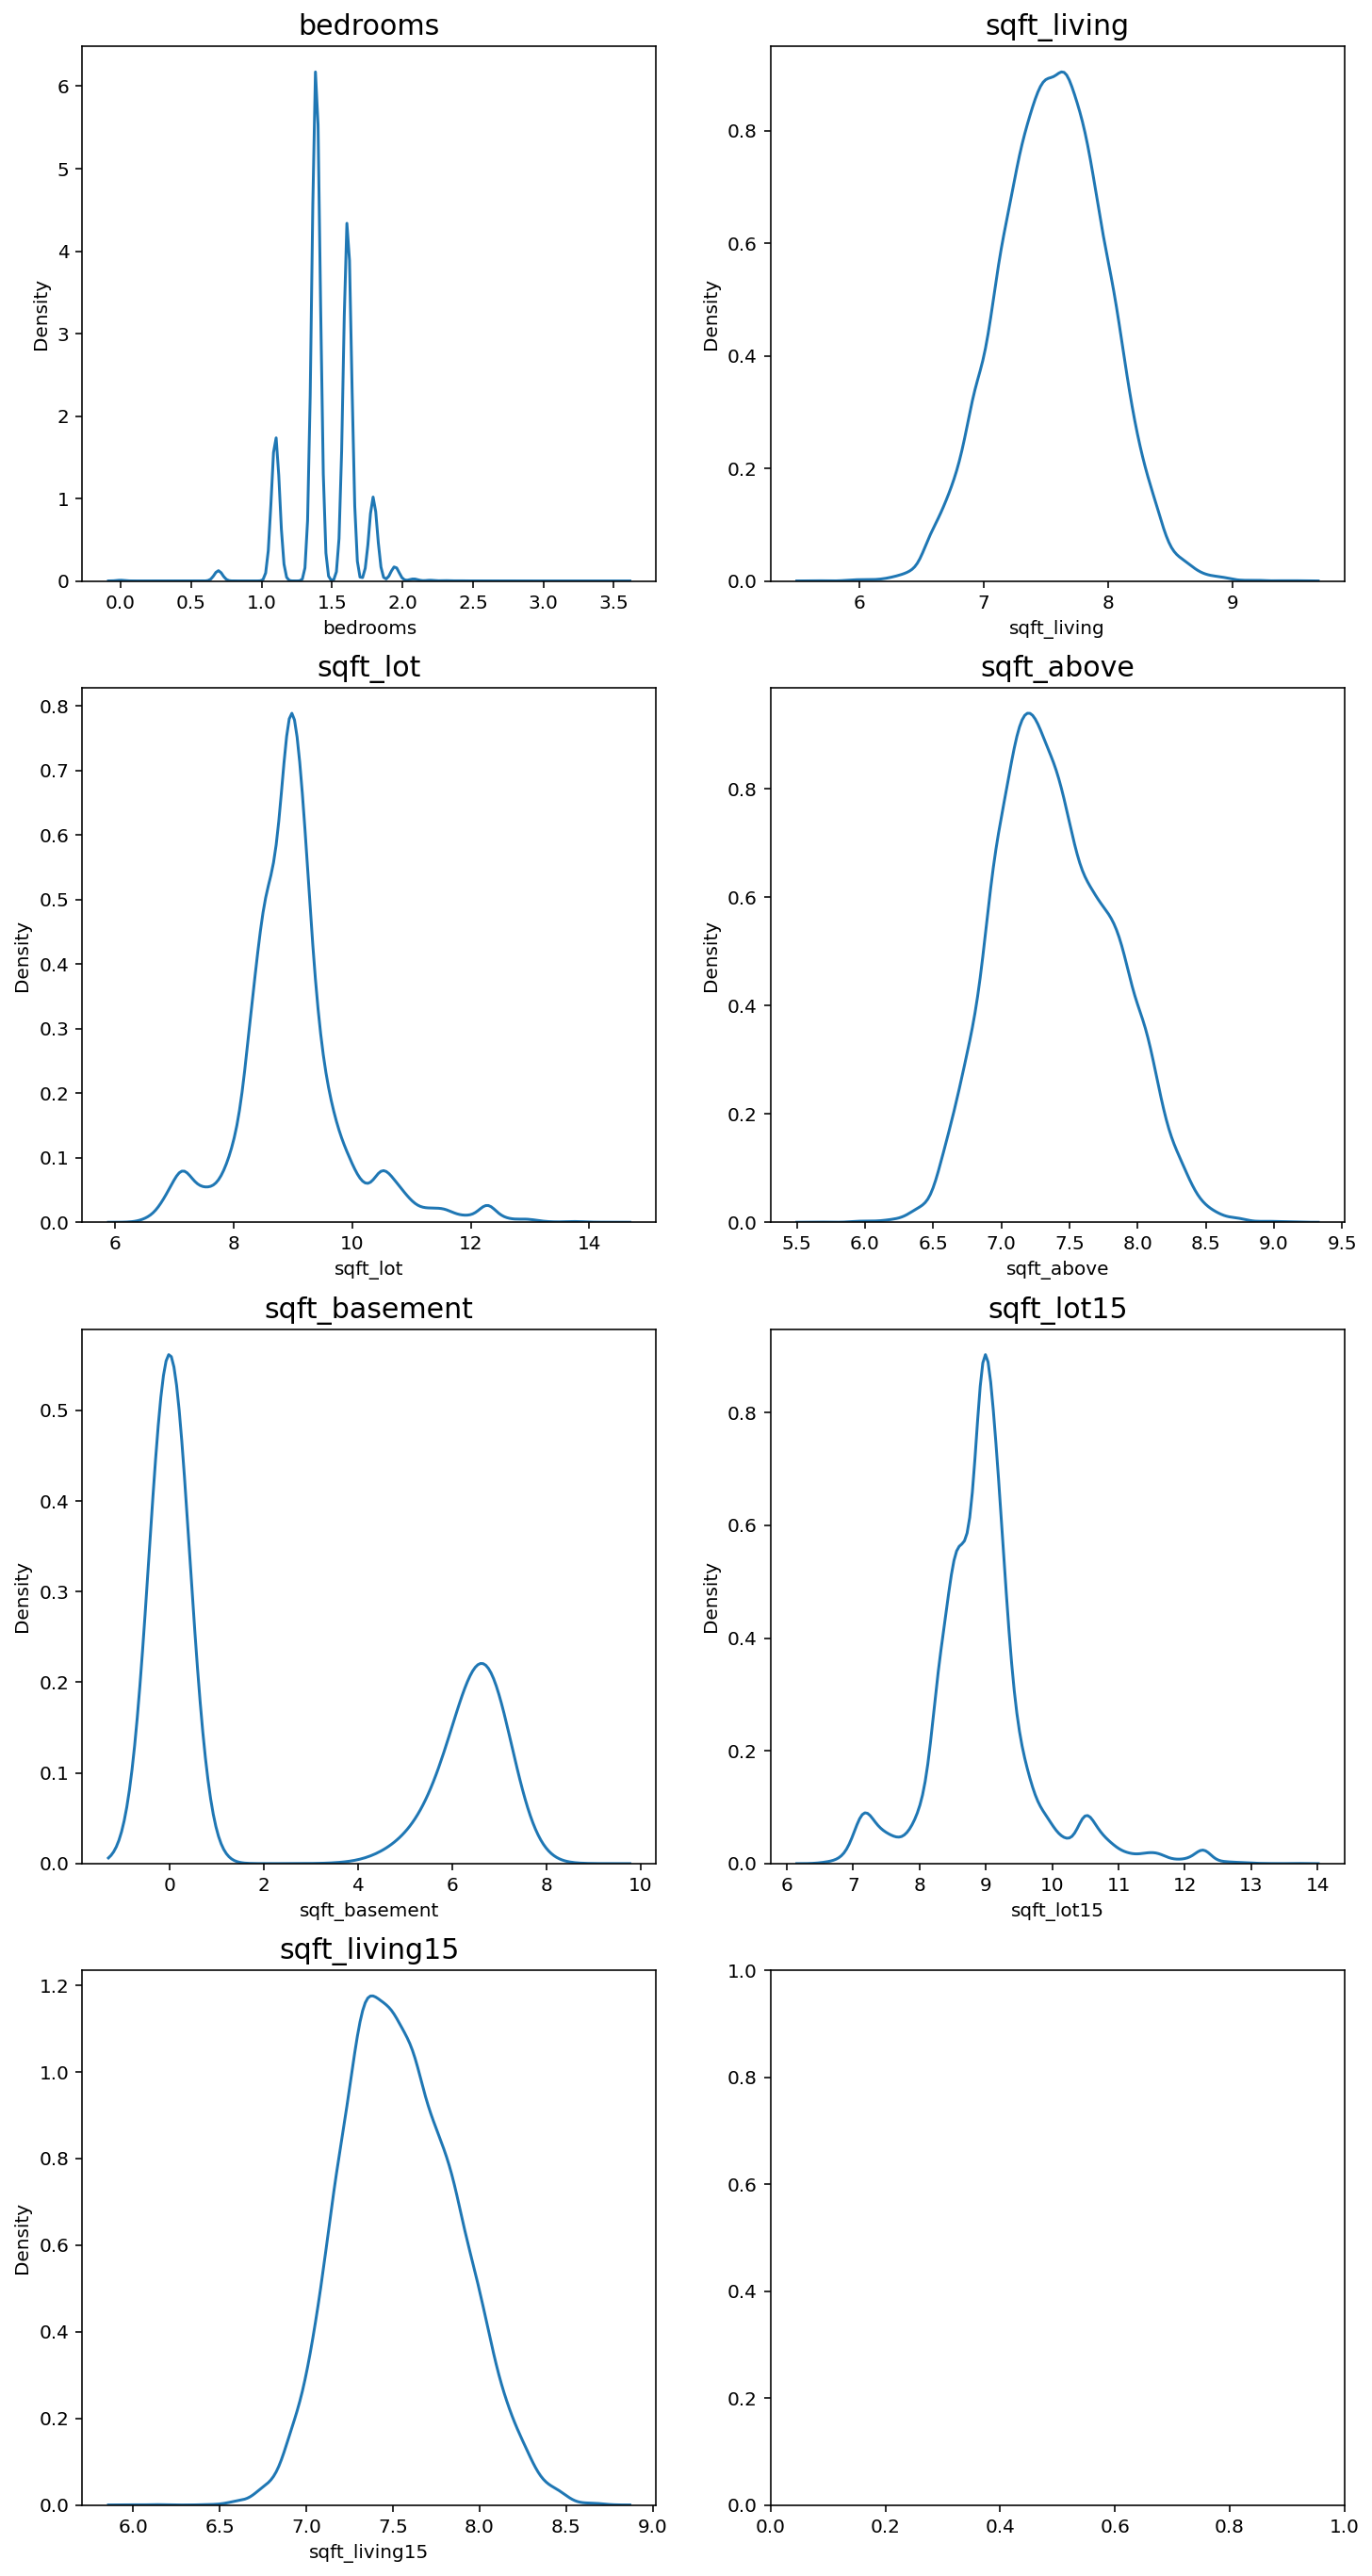

In [13]:
# 치우친 컬럼들을 skew_columns 리스트 안에 담고, 모두 np.log1p()를 활용해서 로그 변환을 해준다.

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)
    # numpy.log1p() 함수는 입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수
    
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

#### 5) 타겟 데이터 확인

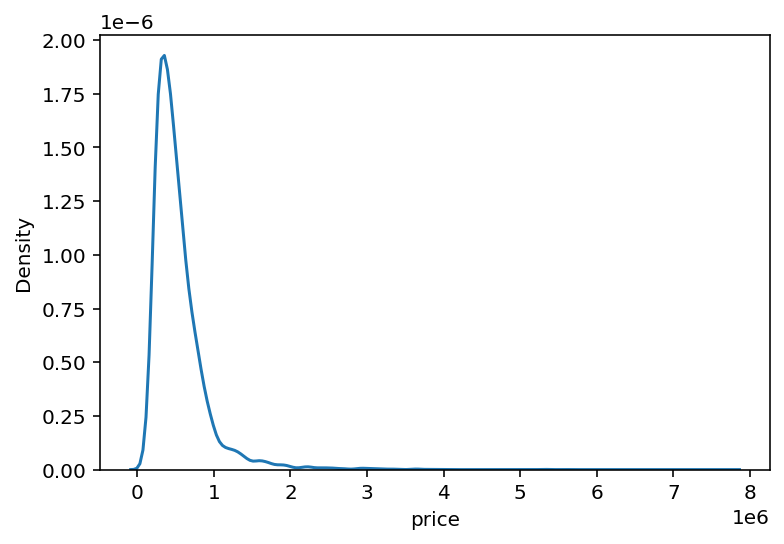

In [14]:
sns.kdeplot(y)
plt.show()

타겟데이터인 price도 왼쪽으로 크게 치우쳐 있는 형태이기에, 로그 변환한 것을 확인해본다.

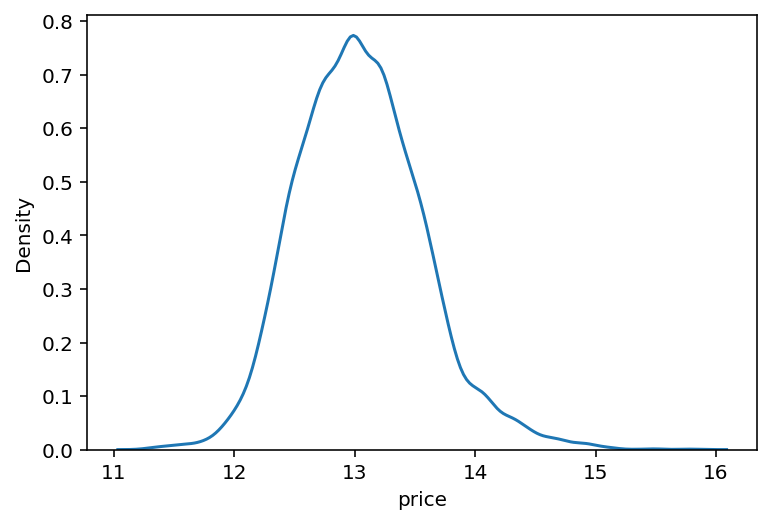

In [15]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

#### 6) 학습 데이터와 테스트 데이터 다시 나누기

위에서 저장해두었던 train_len을 인덱스로 활용해서 학습 데이터와 테스트 데이터를 나눈다.

In [16]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


---

## 4. 모델링

#### 1) Average Blending

여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만든다.<br>
모델은 부스팅 계열인 gboost, xgboost, lightgbm 세 가지를 사용한다.

In [17]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

#### 2) Cross Validation

교차 검증을 통해 모델의 성능을 간단히 평가한다.

In [18]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [19]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


cross_val_score() 함수는 회귀모델을 전달할 경우 R<sup>2</sup>를 반환한다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타낸다.<br>
3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있다.

---

## 5. 제출파일 만들기

훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들어보겠다.

AveragingBlending() 함수 : <br>models 딕셔너리 안에 있는 모델을 모두 x와 y로 학습시킨 뒤 predictions에 그 예측 결괏값을 모아서 평균한 값을 반환한다.

In [20]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([m['model'].predict(sub_x.values) for m in models])
    
    return np.mean(predictions, axis=1)

In [21]:
# 예측값 생성
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [22]:
# 캐글에 제출하기 위해 sample 파일 확인

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [23]:
# sample 파일과 같은 형식으로 데이터프레임 만들기
# id, price 두 가지 열로 구성

result = pd.DataFrame({'id' : sub_id, 'price' : y_pred})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [24]:
# 제출 파일 저장하기

my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


노드를 따라가면서 date 컬럼의 데이터들을 정수형으로 바꾼 것 말고는 변화를 주지 않았는데 118110점이 나왔다.
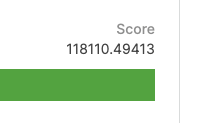

---

## 다시, 랭킹 올리기 도전해보자

하이퍼파라미터 튜닝해보면서 모델의 성능을 끌어올려 보기

### 1. 데이터 가져오고 전처리하기

In [25]:
# 데이터 가져오기

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# train 데이터 전처리

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) # date를 정수형 데이터로 전처리
y = train['price'] # 타겟 데이터 price 분리
del train['price']
del train['id'] # id 컬럼 삭제


# test 데이터도 똑같이 전처리 (price 처리 제외)

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

타겟데이터 y 확인<br>
앞서 살펴봤듯이 price가 왼쪽으로 크게 치우쳐 있는 형태를 보였기 때문에,<br>
y를 np.log1p() 함수를 통해 로그 변환을 해주고, 나중에 모델이 값을 예측한 후에 다시 np.expm1() 활용해서 되돌릴 예정이다.<br>
np.expm1()은 np.log1p()와는 반대로 각 원소 x마다 exp(x)-1의 값을 반환해준다.

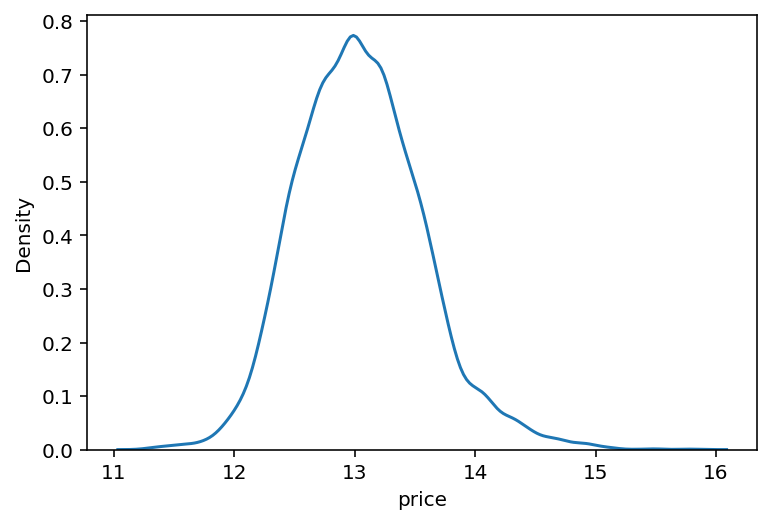

In [26]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [27]:
# 전체데이터의 자료형 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

---

### 2. 모델 튜닝하기

In [28]:
# 필요한 라이브러리 import

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


#### 여러 반복되는 작업들 함수로 만들어놓기

##### RMSE 계산 함수

y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에<br>
원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 한다.<br>
exp로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 취하면 RMSE 값을 얻을 수 있다.

In [29]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [30]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값 
# random_state=None    # 이게 초기값. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택 
random_state=2022        # 하지만 나는 2022로 고정값 세팅

# model 인스턴스 생성 후 models라는 리스트에 넣어주기
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [31]:
# 4가지 모델에 대해 모두 RMSE값 구하기

df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 130361.23368538941,
 'XGBRegressor': 127865.51864932069,
 'LGBMRegressor': 120099.06723661404,
 'RandomForestRegressor': 135139.59142571784}

In [32]:
# 위의 과정을 get_scores() 함수로 만들기

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
RandomForestRegressor,135139.591426
GradientBoostingRegressor,130361.233685
XGBRegressor,127865.518649
LGBMRegressor,120099.067237


---

### 3. 그리드 탐색 (하이퍼 파라미터 튜닝)

In [33]:
from sklearn.model_selection import GridSearchCV

# param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
param_grid = {'n_estimators': [50, 100], 'max_depth': [1, 10],}

# 모델 준비 : lightGBM(lgbm)
model = LGBMRegressor(random_state=random_state)

# GridSearchCV 이용해서 grid_model 초기화
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

# 모델 학습
grid_model.fit(train, y)

# 이렇게 하면 param_grid 내의 모든 하이퍼 파라미터의 조합에 대해 실험이 완료됨

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2022), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

GridSearchCV에 입력되는 인자들
- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- scoring : 모델의 성능을 평가할 지표
- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

실험에 대한 결과확인 (grid_model.cv_results_ 안에 저장됨)

In [34]:
# 각 파라미터들의 조합
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [35]:
# 각각에 대한 테스트 점수
score = grid_model.cv_results_['mean_test_score']
score
# 위에서 grid_model 초기화 시 scoring 인자에 'neg_mean_squared_error' 넣어서 점수가 음수로 표기됨

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [36]:
# 최적 성능 내는 하이퍼파라미터 조합 찾기 위해 살펴보기
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [37]:
# RMSE 점수로 변환
results['RMSE'] = np.sqrt(-1 * results['score'])
results    # log변환된 price 데이터에서 RMSE를 구한 것이므로 실제로는 RMSLE이다.

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [38]:
# 컬럼 이름 RMSLE(Root Mean Squared Log Error)로 변환
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [39]:
# RMSLE가 낮은 순서대로 정렬
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


##### 이 과정을 하나의 함수로 만들기!

In [40]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 'model'을 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

---

### 4. 제출과정 함수로 만들기

In [41]:
# 먼저 위에서 만들어놓은 my_GridSearch 함수로 간단한 그리드 탐색

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [42]:
# 가장 좋은 조합의 파라미터로 구성된 모델 준비, 학습 후 예측 결과 생성

model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction) # 예측결과 원래 스케일로 되돌리기
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [43]:
# 샘플 파일 가져오기

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [44]:
# 모델이 예측한 값 덮어씌워서 제출 데이터 완성

submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [45]:
# csv 파일로 저장
# 파일 이름에 모델의 종류와 위에서 확인했던 RMSLE 값을 넣어주면 제출 파일들이 깔끔하게 관리됨

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


##### 이 과정을 하나의 함수로 만들기!

In [46]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    
    # 모델 학습
    model.fit(train, y)

    # 'test'에 대해 예측
    prediction = model.predict(test)
    
    # 예측값 변환
    prediction = np.expm1(prediction)
    
    # 샘플 파일 가져오기
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    # 모델이 예측한 값 덮어씌워서 제출 데이터 완성
    submission['price'] = prediction
    
    # 'submission_model_name_RMSLE_100000.csv' 형태의 csv 파일로 저장
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

함수 사용해보면 모델 학습시킨 후에 예측 결과 저장까지 한번에 된다.

In [47]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


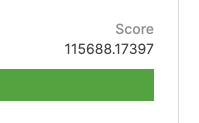

점수가 조금 줄긴 했다.

---

함수로 인해서 편해졌으니 랭킹 올리기에 계속 도전해보자!

#### 시도해볼 수 있는 방법
- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기

#### 튜닝해볼 수 있는 모델 클래스 인자

대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같다.
- max_depth : 의사 결정 나무의 깊이, 정수 사용
- learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
- n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
- num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
- boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

## 11만점 이하로 점수 낮추기!

#### 첫번째 시도 : 가장 간단한 그리드 탐색의 하이퍼파라미터 변경부터

In [48]:
# 데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# train 데이터 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) # date를 정수형 데이터로 전처리
y = train['price'] # 타겟 데이터 price 분리
del train['price']
del train['id'] # id 컬럼 삭제


# test 데이터도 똑같이 전처리 (price 처리 제외)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

# 타겟데이터 y log변환
y = np.log1p(y)

In [49]:
param_grid = {
    'max_depth': [1, 10, 20],
    'n_estimators': [100, 400, 700],
    'learning_rate': [0.005, 0.05, 0.1],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
14,0.050,10,700,-0.025881,0.160877
17,0.050,20,700,-0.026031,0.161341
13,0.050,10,400,-0.026036,0.161355
22,0.100,10,400,-0.026121,0.161619
16,0.050,20,400,-0.026156,0.161728
25,0.100,20,400,-0.026206,0.161883
23,0.100,10,700,-0.026454,0.162648
26,0.100,20,700,-0.026517,0.162839
21,0.100,10,100,-0.027027,0.164399
24,0.100,20,100,-0.027051,0.164472


In [50]:
model = LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=700, random_state=random_state)
save_submission(model, train, y, test, 'lgbm', rmsle='0.160877')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.160877.csv saved!


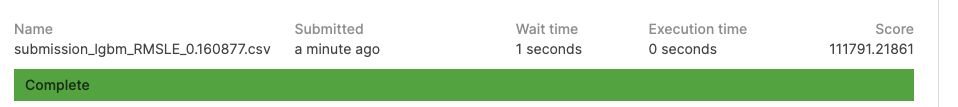


아슬아슬하게 아쉽다.

lgbm에 관해 찾아보던 중 n_estimators, 즉 반복량이 100 단위는 너무 작은편이고, 1000이상을 해야한다고 한다.

In [51]:
# 데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# train 데이터 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) # date를 정수형 데이터로 전처리
y = train['price'] # 타겟 데이터 price 분리
del train['price']
del train['id'] # id 컬럼 삭제


# test 데이터도 똑같이 전처리 (price 처리 제외)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

# 타겟데이터 y log변환
y = np.log1p(y)

In [52]:
param_grid = {
    'max_depth': [1, 10, 20],
    'n_estimators': [1000, 1500, 2000],
    'learning_rate': [0.005, 0.05, 0.1],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
12,0.050,10,1000,-0.025930,0.161028
15,0.050,20,1000,-0.026044,0.161381
13,0.050,10,1500,-0.026219,0.161922
16,0.050,20,1500,-0.026258,0.162044
14,0.050,10,2000,-0.026450,0.162633
17,0.050,20,2000,-0.026466,0.162682
8,0.005,20,2000,-0.026704,0.163414
21,0.100,10,1000,-0.026739,0.163521
5,0.005,10,2000,-0.026782,0.163652
24,0.100,20,1000,-0.026786,0.163663


In [53]:
model = LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=1000, random_state=random_state)
save_submission(model, train, y, test, 'lgbm', rmsle='0.161028')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161028.csv saved!


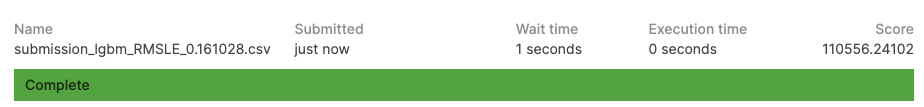

556점 남았다.

이후에 여러 다른 하이퍼파라미터를 추가해서 몇번 돌려봤는데, 계속 error가 뜨거나 결과값이 이상하게 나오는 경우가 많았다.
구글링을 해보니 새로운 하이퍼파라미터를 잘 모르는 상태에서 쓰는 것은 안쓰는 것보다 못하다고 하여.. 일단 하이퍼파라미터 튜닝은 여기서 끝내야겠다.


#### 두번째 시도 : 피처 엔지니어링

위에서 데이터를 살펴보다가 왼쪽으로 치우쳐져 있는 변수들을 무시하고 넘어가기가 힘들어서, 이상치를 한번 확인해보고 제거한 뒤에 다시 시도해보겠다.

In [54]:
# 데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# train 데이터 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) # date를 정수형 데이터로 전처리
y = train['price'] # 타겟 데이터 price 따로 저장

# test 데이터도 똑같이 전처리 (price 처리 제외)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)


In [55]:
y.describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

일단 price의 분포도 위에서 확인해봤듯이 왼쪽으로 굉장히 치우쳐져 있었다. 확인해보니 최소값과 최대값의 차이가 너무 크고, 표준편차도 굉장히 컸다. 비정상적으로 높은 가격의 집들이 몇 개 있다는 것이다.

굉장히 높게 가격이 형성되어 있는 집들에 영향을 주는 변수는 무엇인지를 알아보고 싶었다.
<br> 그전에 변수들과 가격의 상관관계를 알기 위해서 상관도가 높은 변수의 순서대로 상위 10개의 스피어만 순위 상관관계를 보는 히트맵을 캐글에서 가져와봤다.

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

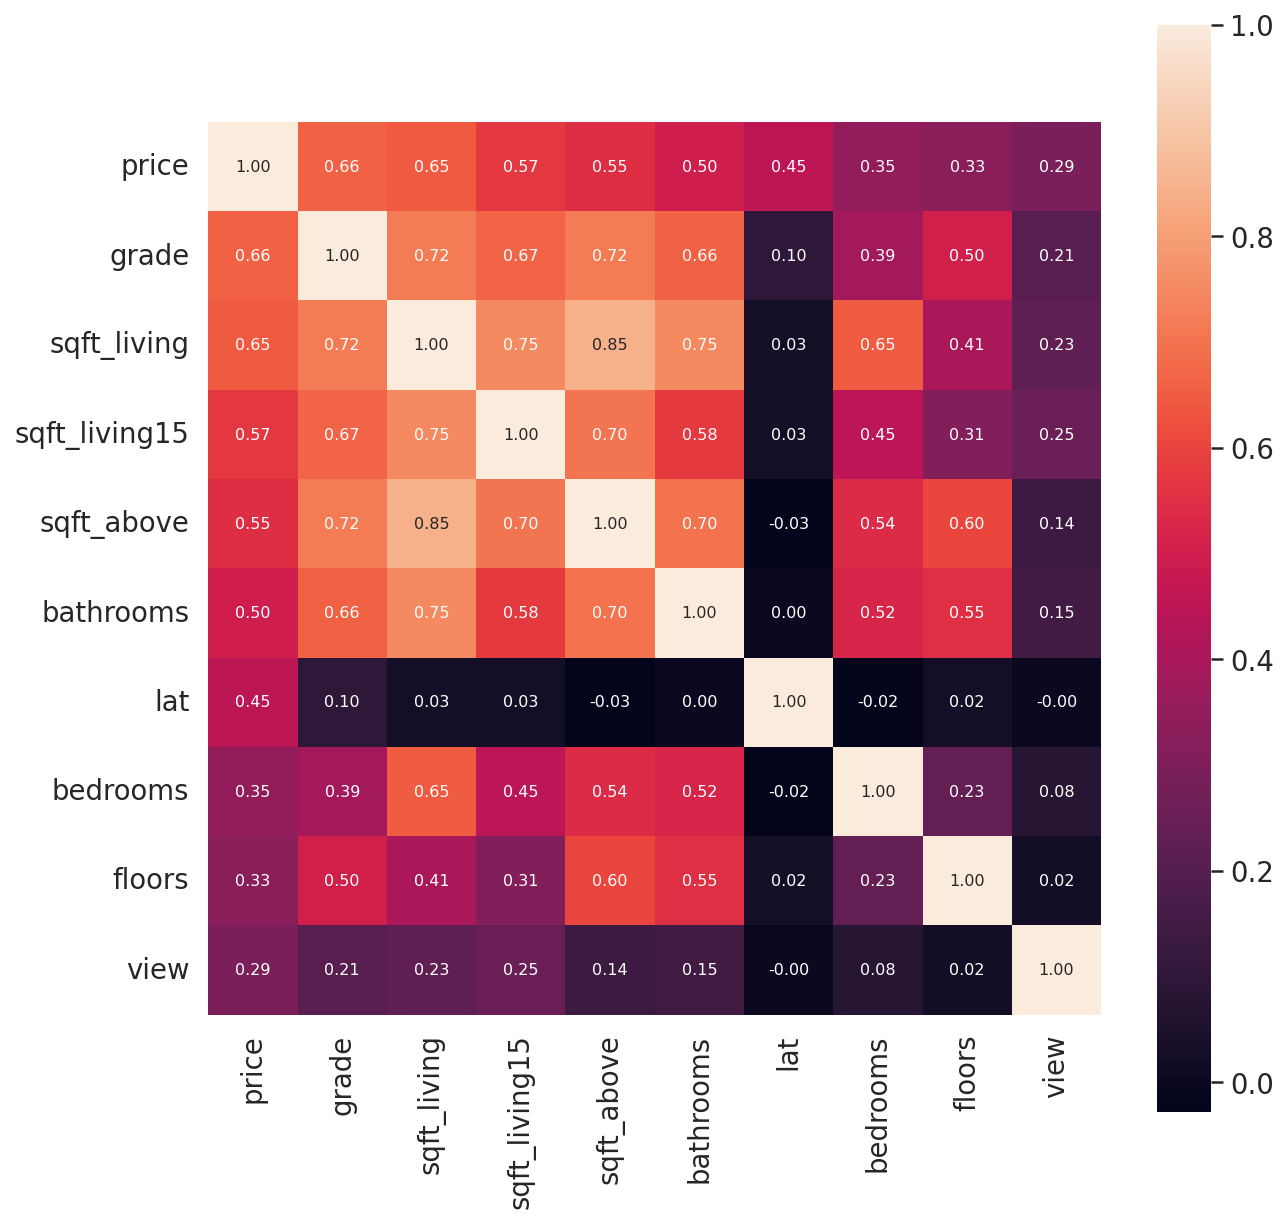

In [56]:
# correlation이 높은 상위 10개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
# https://www.kaggle.com/junoindatascience/let-s-eda-it 준호님이 수정해 준 코드로 사용하였습니다. 
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

grade, sqft_living, sqft_living15 등이 가격과 높은 상관관계를 갖는 것으로 나온다.

In [57]:
y = np.log1p(y)

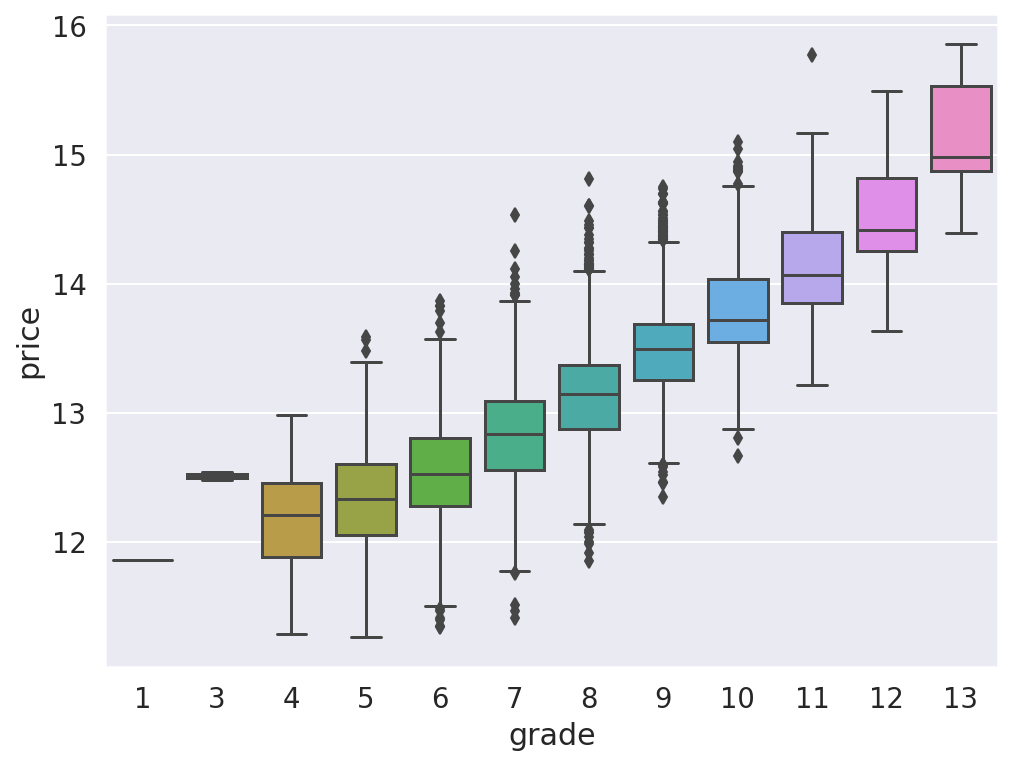

In [58]:
data = pd.concat([y, train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y='price', data=data)

대체로 grade가 높아질수록 price도 높아지지만, grade 3의 형태가 좀 이상하고, grade 7, 8, 11에서 이상치가 발견이 된다.

각각의 이상치를 확인해보자.

In [59]:
train.loc[(y > 12) & (train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,201502,262000.0,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,201411,280000.0,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [60]:
train.loc[(y > 14.5) & (train['grade'] == 7)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,12346,201501,2050000.0,4,3.25,3580,19989,1.5,1,4,...,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


In [61]:
train.loc[(y > 14.8) & (train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,201408,2700000.0,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [62]:
train.loc[(y > 15.5) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,7062500.0,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


특별한 이유가 없는 이상치들은 모델 학습에 방해되므로 제거해주자.

In [63]:
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]
train = train.loc[train['id']!=12346]
train = train.loc[train['id']!=7173]
train = train.loc[train['id']!=2775]

그 다음 sqft_living에서의 이상치도 확인해보자.

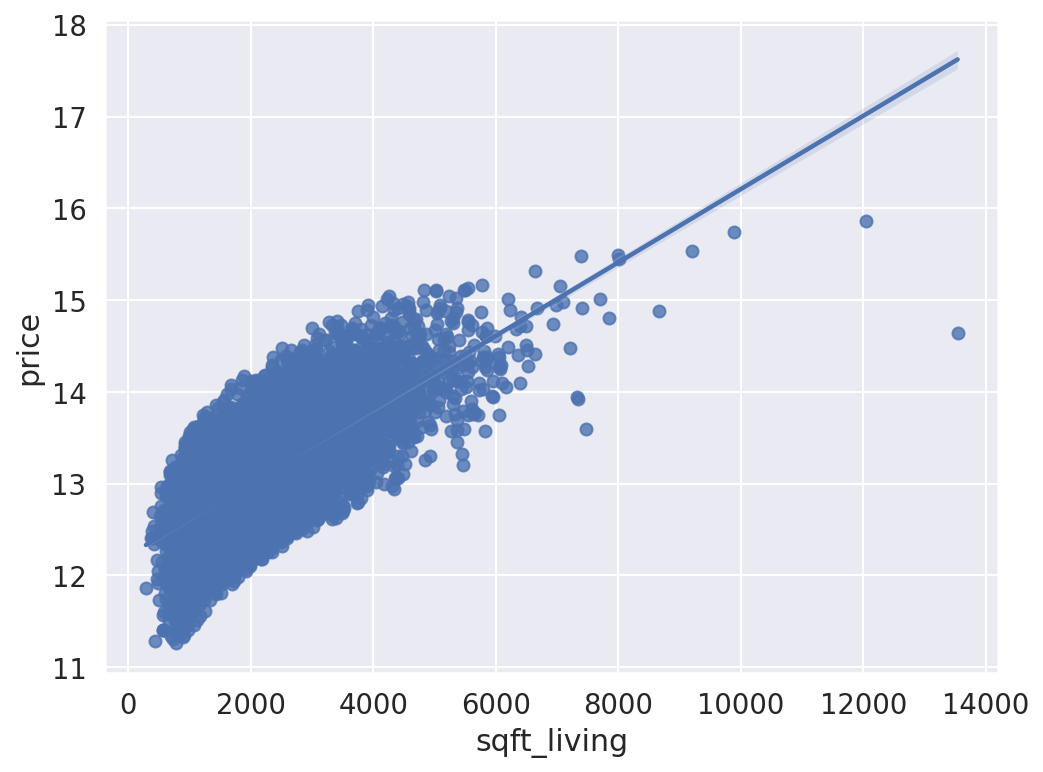

In [65]:
data = pd.concat([y, train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

아까 언급했었던 가격이 비정상적으로 높았던 집들의 이유가 있었다. sqft_living, 주거 면적이 굉장히 넓은 집이었던 것이다. 근데 맨 오른쪽의 점을 보면 주거면적이 굉장히 넓은데에 비해 가격이 어울리지 않다는 것을 알 수 있다. 저것이 바로 이상치가 될 것이다. 한번 데이터를 확인해보겠다.

In [66]:
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,201405,2280000.0,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


다른 변수들에 비해 sqft_living만 비정상적으로 크다. 모델이 학습하는데에 방해가 될 요소이므로 제거해야겠다.

In [67]:
train = train.loc[train['id']!=8912]

sqft_living15에서의 이상치도 확인해보자.

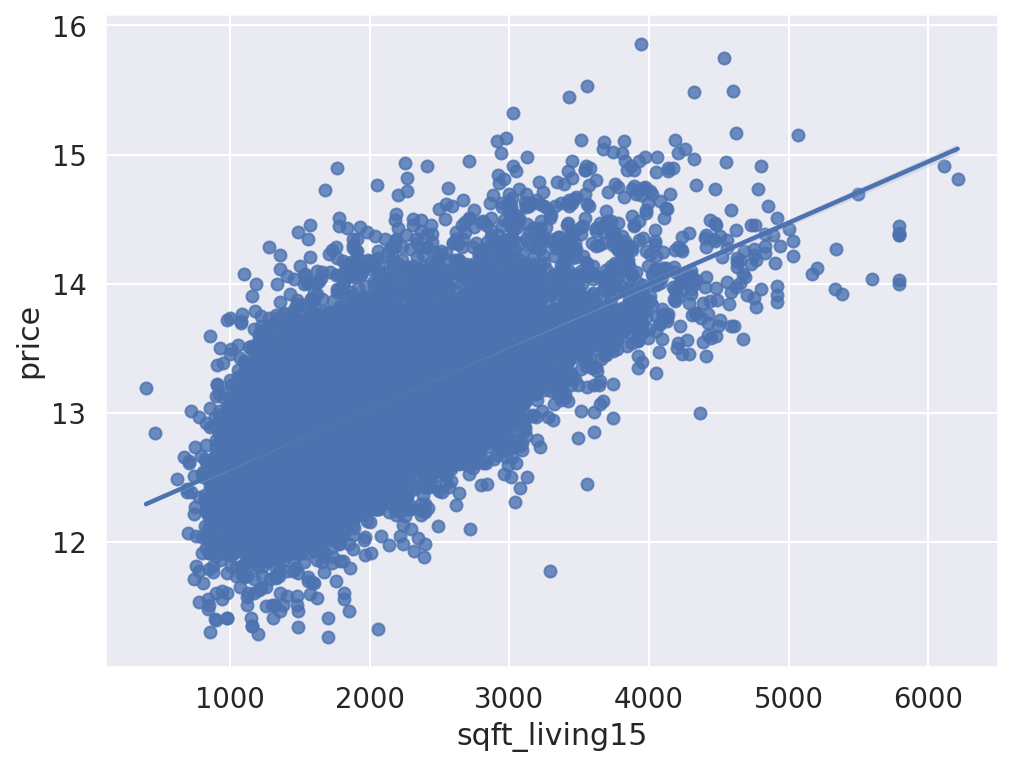

In [68]:
data = pd.concat([y, train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

앞에서 이상치들을 제거하고 나니깐 sqft_living15에서의 이상치는 거의 없어보인다.

이제 price와 id 컬럼 삭제해주고 진행해보겠다.

In [69]:
y = np.log1p(train['price']) # y를 이상치들 제거한 목록에 대한 타겟데이터로 다시 세팅
del train['price']
del train['id']
del test['id']

In [70]:
param_grid = {
    'max_depth': [1, 10, 20],
    'n_estimators': [1000, 1500, 2000],
    'learning_rate': [0.005, 0.05, 0.1],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
12,0.050,10,1000,-0.025712,0.160349
13,0.050,10,1500,-0.025908,0.160958
15,0.050,20,1000,-0.025933,0.161038
16,0.050,20,1500,-0.026093,0.161535
14,0.050,10,2000,-0.026114,0.161600
17,0.050,20,2000,-0.026295,0.162158
21,0.100,10,1000,-0.026507,0.162810
24,0.100,20,1000,-0.026653,0.163258
8,0.005,20,2000,-0.026660,0.163278
5,0.005,10,2000,-0.026680,0.163339


In [71]:
model = LGBMRegressor(learning_rate=0.05, max_depth=10, n_estimators=1000, random_state=random_state)
save_submission(model, train, y, test, 'lgbm', rmsle='0.160349')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.160349.csv saved!


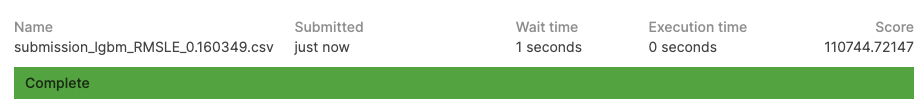

피처 엔지니어링을 했더니 오히려 점수가 다시 안좋아졌다.

#### 세번째 시도 : 모델 바꿔보기

XGBRegressor로 모델을 바꿔봐야겠다.

In [72]:
# 데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# train 데이터 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) # date를 정수형 데이터로 전처리
y = train['price'] # 타겟 데이터 price 분리
del train['price']
del train['id'] # id 컬럼 삭제


# test 데이터도 똑같이 전처리 (price 처리 제외)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

# 타겟데이터 y log변환
y = np.log1p(y)

In [73]:
model = XGBRegressor(
    learning_rate =0.1,
    max_depth=10,
    n_estimators=1000,
)
save_submission(model, train, y, test, 'XGB', rmsle='unknown')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_XGB_RMSLE_unknown.csv saved!


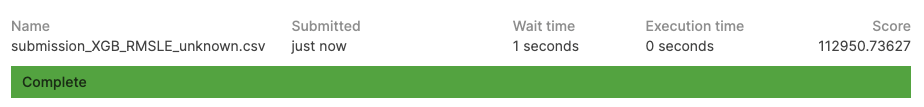

점수가 더 안좋아졌다..
<br> XGBRegressor는 그리드 탐색을 하는데 너무 오랜시간이 걸리고 자꾸 에러가 떠서, 일일이 하나씩 다 조정해서 해봐야한다.
<br> 제일 민감한 하이퍼파라미터라고 하는 max_depth를 변화시켜봐야겠다.

In [74]:
# 데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# train 데이터 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) # date를 정수형 데이터로 전처리
y = train['price'] # 타겟 데이터 price 분리
del train['price']
del train['id'] # id 컬럼 삭제


# test 데이터도 똑같이 전처리 (price 처리 제외)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

# 타겟데이터 y log변환
y = np.log1p(y)

In [75]:
model = XGBRegressor(
    learning_rate =0.1,
    max_depth=5,
    n_estimators=1000,
)
save_submission(model, train, y, test, 'XGB', rmsle='unknown1')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_XGB_RMSLE_unknown1.csv saved!


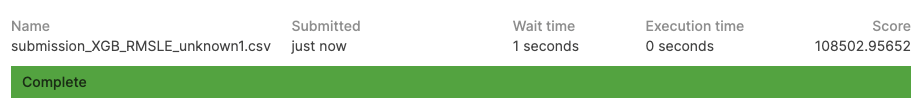

108502점! 드디어 11만점 밑으로 들어왔다.

---

## 회고

- 일단 처음엔 캐글의 문제를 풀어본다는 것이 기대되고 재밌었는데, 나중에 계속 11만점 밑으로 못내려오니깐 너무 힘들었다. 어떻게든 11만점을 깨려고 캐글에 올라온 다른 사람들의 커널(?) 노트북(?)을 다 공부해보고 코드를 가져와보기도 하고 했는데, 그 과정에서 새로 공부하고 알게된 것도 많고 훈련이 된 것도 있지만.. 이것 저것 다 시도해보고 다시 코드블록 몇십개를 지우고 다시 쓰고 하다보니 시간도 너무 오래 뺏기고 힘들었다.

- 첫번째 시도였던 그리드 탐색을 이용해서 더 나은 하이퍼 파라미터를 찾아서 적용해나갈 때는 계속 점수가 가까워져서 괜찮은가 싶었다. 위에서 봤던 모델들 중에 가장 성능이 좋은 LGBM을 쓰는 것이었기 때문에 다른 모델을 쓰는 것은 생각도 안하고 있었다. 근데 아무리 하이퍼 파라미터를 바꿔봐도 계속 몇백 점 차이로 11만점을 깨지 못했다.


- 그래서 두번째 시도에서 한번 피처 엔지니어링이란 것을 시도해봤다. 아직 파이썬 코드 짜는것도 부족하고 심지어 데이터 전처리하는 능력은 더욱 부족해서 처음엔 너무 막막했는데, 다른 사람들의 캐글 커널을 쭉 찾아보면서 내가 원하는 방향으로 피처들을 손보는 방법들을 차용해와서 써봤다. 근데 이상치만 제거한다고 해서 모델이 예측을 잘하는 것은 아니라는 것을 이번에 절실히 깨달았다. 여러번 해봐도 하면 할수록 더 못맞히게 되는 것 같았다. 데이터 전처리 과정에 대해 별로 흥미가 없었어서 그동안 대충 보고 넘겼었는데, 이번에 정말 데이터 전처리 과정이 얼마나 까다롭고 복잡한지를 깨달았다. 그리고 사람들의 노트북을 보니 대부분 EDA에 어마어마한 노력을 쏟고 있었다. 더 공부해서 모델이 예측을 잘할 수 있는 전처리에 대해 감이라도 잡을 수 있도록 노력해야겠다고 생각했다.


- 두번째 시도에서 너무 지쳐서 세번째 시도에서는 아예 처음부터 시작하고 모델을 바꿔봐야겠다고 생각했다. 앞서 네 개의 모델 중 LGBM 다음으로 좋은 score를 보여준 XGB를 쓰기로 했는데, 그리드 탐색을 진행하니깐 무슨 1시간 넘게 걸리도록 처리가 안되고 계속 기다려야 하는 상황이 발생했다. 또 계속 warning이 뜨고 난리가 났다. 그래서 그냥 파라미터를 내가 하나씩 입력해보면서 계속 알맞을 것 같은 방향으로 모델을 만들어보니깐 어느 순간 11만점 아래로 내려왔다. 그걸 보는 순간 이 노드를 더 이상 건드리고 싶지 않았다.


- 내가 지금 실력으로 캐글 경진대회에 참여한다면 너무 부족할 것 같다. Baseline 커널이 없는 문제였다면 손도 못댔을 것이다. 그렇지만 이번에 발가락이라도 담가봤으니 앞으로 좀더 열심히 공부해서 언젠간 정말 능력자처럼 내가 쓴 코드에 대한 아이디어를 공유하고 캐글에 참여할 수 있는 그런 사람이 되고싶다.